In [1]:
%load_ext watermark


In [2]:
import itertools as it
import os

from downstream import dstream
import matplotlib as mpl
import polars as pl
import seaborn as sns
from teeplot import teeplot as tp

import pylib  # noqa: F401


In [3]:
%watermark -diwmuv -iv


Last updated: 2025-07-21T00:39:02.236793+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.8.0-1030-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

polars    : 1.9.0
teeplot   : 1.4.2
seaborn   : 0.13.2
downstream: 1.11.0
pylib     : 0.0.0
matplotlib: 3.10.0

Watermark: 2.4.3



In [4]:
tp.save[".pgf"] = True
teeplot_subdir = os.environ.get(
    "NOTEBOOK_NAME", "2024-10-20-qos-dstream-vs-naive-steady"
)
teeplot_subdir


'2025-01-18-qos-dstream-vs-naive-steady'

In [5]:
num_items = 10_000


## Define


In [6]:
def calc_qos_from_segment_lengths(segment_lengths: list[int]) -> float:
    return max(segment_lengths)


In [7]:
def calc_max_gaps_doubling_steady(
    buffer_size: int, num_ingests: int
) -> list[int]:
    s = int(buffer_size).bit_length()
    return [
        2**max(i.bit_length() - s + 2, 0) - 1
        for i in range(num_ingests)
    ]


In [8]:
def calc_max_gaps_naive_zhao_2006(
    buffer_size: int, num_ingests: int
) -> list[int]:
    segment_lengths = []
    max_gaps = []
    for i in range(num_ingests):
        if len(segment_lengths) < buffer_size:
            segment_lengths.append(1)
            max_gaps.append(max(segment_lengths) - 1)
            continue
        if (
            len(segment_lengths) > 2
            and segment_lengths[-1] < segment_lengths[-2]
        ):
            segment_lengths[-1] += 1
        else:
            target = min(
                range(buffer_size - 1),
                key=lambda i: segment_lengths[i] + segment_lengths[i + 1],
            )
            segment_lengths[target] += segment_lengths[target + 1]
            segment_lengths.pop(target + 1)
            segment_lengths.append(1)

        assert sum(segment_lengths) == i + 1
        max_gaps.append(max(segment_lengths) - 1)
    return max_gaps


In [9]:
def calc_max_gaps_dstream(buffer_size: int, num_items: int) -> list[int]:
    return [
        max(
            b - a - 1
            for a, b in it.pairwise(
                [
                    *sorted(
                        dstream.steady_algo.lookup_ingest_times_eager(
                            buffer_size, i + 1
                        ),
                    ),
                    i,
                ],
            )
        )
        if i >= buffer_size
        else 0
        for i in range(num_items)
    ]


In [10]:
def calc_max_gaps_gunther(buffer_size: int, num_items: int) -> list[int]:
    return [
        max(
            b - a - 1
            for a, b in it.pairwise(
                [
                    *sorted(
                        dstream.compressing_algo.lookup_ingest_times_eager(
                            buffer_size, i + 1
                        ),
                    ),
                    i,
                ],
            )
        )
        if i >= buffer_size
        else 0
        for i in range(num_items)
    ]


## Example Plot


In [11]:
def make_df(buffer_size: int) -> pl.DataFrame:
    return pl.concat(
        [
            pl.DataFrame(
                {
                    "Algorithm": "zhao steady",
                    "Max Gap Size": calc_max_gaps_naive_zhao_2006(
                        buffer_size, num_items
                    ),
                    "Num Items Ingested": range(num_items),
                },
            ),
            pl.DataFrame(
                {
                    "Algorithm": "doubling steady",
                    "Max Gap Size": calc_max_gaps_doubling_steady(
                        buffer_size, num_items
                    ),
                    "Num Items Ingested": range(num_items),
                },
            ),
            pl.DataFrame(
                {
                    "Algorithm": "gunther steady",
                    "Max Gap Size": calc_max_gaps_gunther(buffer_size, num_items),
                    "Num Items Ingested": range(num_items),
                },
            ),
        ],
    )


teeplots/2025-01-18-qos-dstream-vs-naive-steady/buffer_size=64+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=max-gap-size+ext=.pdf
teeplots/2025-01-18-qos-dstream-vs-naive-steady/buffer_size=64+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=max-gap-size+ext=.pgf
teeplots/2025-01-18-qos-dstream-vs-naive-steady/buffer_size=64+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=max-gap-size+ext=.png


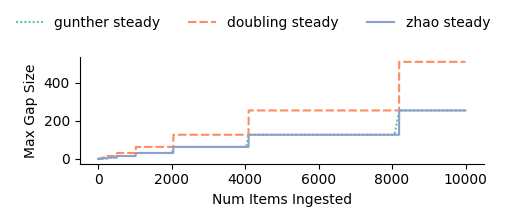

teeplots/2025-01-18-qos-dstream-vs-naive-steady/buffer_size=64+font.family=serif+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=max-gap-size+ext=.pdf
teeplots/2025-01-18-qos-dstream-vs-naive-steady/buffer_size=64+font.family=serif+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=max-gap-size+ext=.pgf
teeplots/2025-01-18-qos-dstream-vs-naive-steady/buffer_size=64+font.family=serif+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=max-gap-size+ext=.png


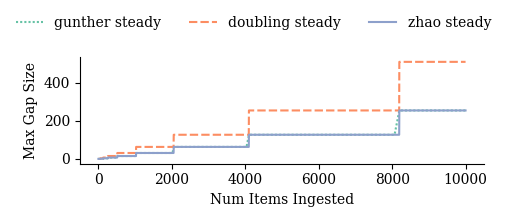

teeplots/2025-01-18-qos-dstream-vs-naive-steady/buffer_size=256+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=max-gap-size+ext=.pdf
teeplots/2025-01-18-qos-dstream-vs-naive-steady/buffer_size=256+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=max-gap-size+ext=.pgf
teeplots/2025-01-18-qos-dstream-vs-naive-steady/buffer_size=256+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=max-gap-size+ext=.png


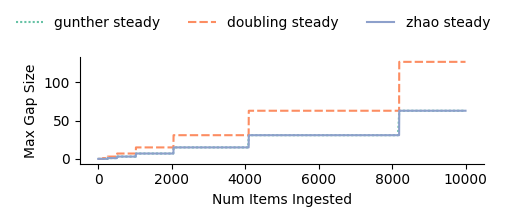

teeplots/2025-01-18-qos-dstream-vs-naive-steady/buffer_size=256+font.family=serif+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=max-gap-size+ext=.pdf
teeplots/2025-01-18-qos-dstream-vs-naive-steady/buffer_size=256+font.family=serif+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=max-gap-size+ext=.pgf
teeplots/2025-01-18-qos-dstream-vs-naive-steady/buffer_size=256+font.family=serif+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=max-gap-size+ext=.png


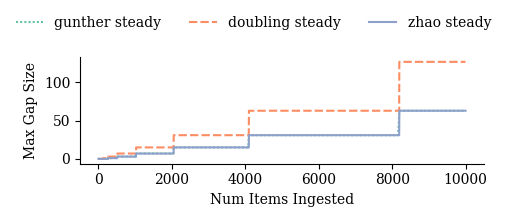

teeplots/2025-01-18-qos-dstream-vs-naive-steady/buffer_size=1024+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=max-gap-size+ext=.pdf
teeplots/2025-01-18-qos-dstream-vs-naive-steady/buffer_size=1024+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=max-gap-size+ext=.pgf
teeplots/2025-01-18-qos-dstream-vs-naive-steady/buffer_size=1024+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=max-gap-size+ext=.png


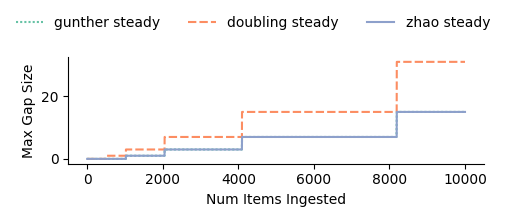

teeplots/2025-01-18-qos-dstream-vs-naive-steady/buffer_size=1024+font.family=serif+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=max-gap-size+ext=.pdf
teeplots/2025-01-18-qos-dstream-vs-naive-steady/buffer_size=1024+font.family=serif+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=max-gap-size+ext=.pgf
teeplots/2025-01-18-qos-dstream-vs-naive-steady/buffer_size=1024+font.family=serif+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=max-gap-size+ext=.png


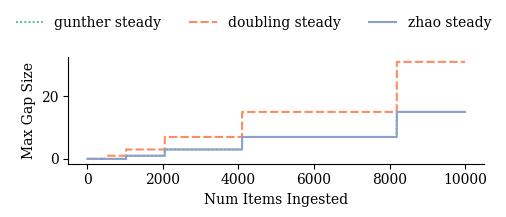

teeplots/2025-01-18-qos-dstream-vs-naive-steady/buffer_size=4096+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=max-gap-size+ext=.pdf
teeplots/2025-01-18-qos-dstream-vs-naive-steady/buffer_size=4096+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=max-gap-size+ext=.pgf
teeplots/2025-01-18-qos-dstream-vs-naive-steady/buffer_size=4096+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=max-gap-size+ext=.png


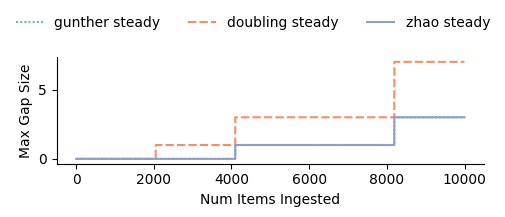

teeplots/2025-01-18-qos-dstream-vs-naive-steady/buffer_size=4096+font.family=serif+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=max-gap-size+ext=.pdf
teeplots/2025-01-18-qos-dstream-vs-naive-steady/buffer_size=4096+font.family=serif+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=max-gap-size+ext=.pgf
teeplots/2025-01-18-qos-dstream-vs-naive-steady/buffer_size=4096+font.family=serif+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=max-gap-size+ext=.png


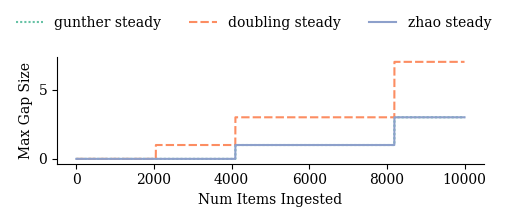

In [12]:
for buffer_size in [64, 256, 1024, 4096]:
    df = make_df(buffer_size)
    for rc in [{}, {"font.family": "serif"}]:
        with mpl.rc_context(rc=rc):
            with tp.teed(
                sns.relplot,
                df,
                x="Num Items Ingested",
                y="Max Gap Size",
                hue="Algorithm",
                hue_order=[
                    "gunther steady",
                    "doubling steady",
                    "zhao steady",
                ],
                style="Algorithm",
                aspect=2.8,
                kind="line",
                height=1.8,
                palette="Set2",
                teeplot_outattrs={
                    "buffer_size": buffer_size,
                    **rc,
                },
                teeplot_subdir=teeplot_subdir,
            ) as g:
                sns.move_legend(
                    g,
                    "lower center",
                    bbox_to_anchor=(0.4, 1),
                    ncol=3,
                    title=None,
                    frameon=False,
                )
